# PCA: Special Case Where PC1=0 or PC2=0

In [1]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation, Summarizer

import time
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

Matplotlib created a temporary cache directory at /tmp/matplotlib-ldmg9mw5 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 8
memory_per_node = 64

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

sc.getActiveSession()

Driver memory: 64g
Executor memory: 8g
Number of executors: 7

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
%%time
### Load datasets

### Open the preprocessed dataset
df = sqlContext.read.load("preprocessed_df_subset/preprocessed_df_subset.parquet") \
               .select("id", "ss_id", "stamp_date", "power_kW_values", "reconstructions", "recon_PC1", "recon_PC2")
# df_count = df.count()

# metadata
meta_filename = "metadata_preprocessed.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

df.show(1)


+---+-----+----------+--------------------+--------------------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|     reconstructions|           recon_PC1|           recon_PC2|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+
|  0| 2405|2012-01-21|[0.0, 0.0, 0.0, 0...|[0.00410907621307...|-0.41782595826965074|-0.02458836598737569|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row

CPU times: user 80.6 ms, sys: 14.9 ms, total: 95.4 ms
Wall time: 4.15 s


In [4]:
Q1 = df_meta["kwp"].quantile(0.25)

print(Q1)

2.28


In [5]:
### Filter out PC1 > 1 and PC2 > 1
df2 = df.where((F.col("recon_PC1")<1) & (F.col("recon_PC2")<1))

In [92]:
### Create function to vectorize the power/reconstruction lists
def vectorize_lists(df):
    ### Instantiate vector assemblers to help generate average curves
    assemble_power = VectorAssembler(inputCols = [f"power_kW_values[{i}]" for i in range(0,48)], outputCol="power_kW_values2")
    assemble_recon = VectorAssembler(inputCols = [f"reconstructions[{i}]" for i in range(0,48)], outputCol="reconstructions2")
    
    df = assemble_power.transform(df.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
    df = assemble_recon.transform(df.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
    df = df.select("id", "ss_id", "stamp_date", "recon_PC1", "recon_PC2", "power_kW_values2", "reconstructions2")

    return df

# Explore when PC1 = PC2 = 0

Viewing a subset of the data
+----+-----+----------+--------------------+--------------------+---------+---------+
|  id|ss_id|stamp_date|     power_kW_values|     reconstructions|recon_PC1|recon_PC2|
+----+-----+----------+--------------------+--------------------+---------+---------+
| 964| 2459|2016-04-29|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|      0.0|      0.0|
| 965| 2459|2016-10-25|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|      0.0|      0.0|
| 966| 2459|2017-03-07|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|      0.0|      0.0|
|1555| 2492|2016-09-17|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|      0.0|      0.0|
|1556| 2492|2016-11-30|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|      0.0|      0.0|
+----+-----+----------+--------------------+--------------------+---------+---------+
only showing top 5 rows

Number of rows: 476230


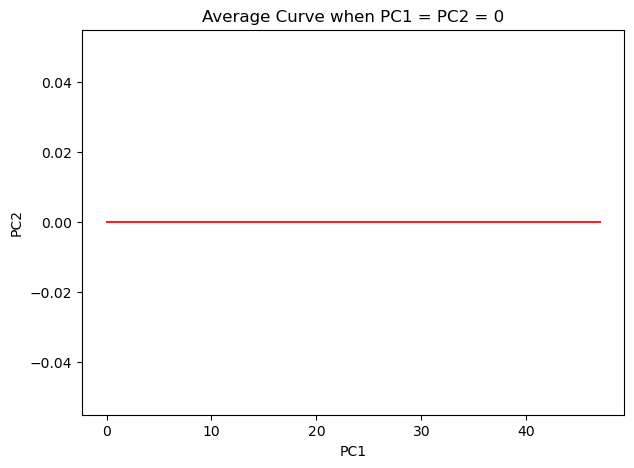

In [93]:
### Filter the data
df_zeros = df2.where((F.col("recon_PC1")==0) | (F.col("recon_PC2")==0))

#######################################################
print("Viewing a subset of the data")
df_zeros.show(5)
print(f"Number of rows: {df_zeros.count()}")

### Vectorize the lists and extract the mean powers/reconstructions
df_zeros2 = vectorize_lists(df_zeros)
    
zeros_mean_powers = list(df_zeros2.agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
zeros_mean_recons = list(df_zeros2.agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])

### Set up x axis for plotting
x = [i for i in np.arange(0,48)]

### Plot the mean values
fig,ax = plt.subplots(1,1, figsize=(7,5))
plt.plot(x, zeros_mean_powers, "k", alpha=0.25)
plt.plot(x, zeros_mean_powers, "r", alpha=0.8)
ax.set(xlabel="PC1", ylabel="PC2", title="Average Curve when PC1 = PC2 = 0")

plt.show()

### Add PC1=PC2=0 to anomalies

Viewing a subset of the data
+-----+-----+----------+--------------------+--------------------+--------------------+--------------------+
|   id|ss_id|stamp_date|     power_kW_values|     reconstructions|           recon_PC1|           recon_PC2|
+-----+-----+----------+--------------------+--------------------+--------------------+--------------------+
| 3860| 2643|2016-12-08|[0.0, 0.0, 0.0, 0...|[7.55822832257850...|-0.04950725777424851|-0.00370906359570...|
| 4399| 2682|2013-11-27|[0.0, 0.0, 0.0, 0...|[-0.0012735093128...|-0.04950204921480596|-0.00345251282223...|
|10739| 3098|2012-12-31|[0.0, 0.0, 0.0, 0...|[7.60489163653941...|-0.04950781806653738|-0.00390480154943...|
|13814| 3314|2019-10-26|[0.0, 0.0, 0.0, 0...|[6.97557838508443...|-0.04998149898646835|-0.00372977833250...|
|15484| 3423|2013-01-02|[0.0, 0.0, 0.0, 0...|[-9.3055906056761...| -0.0508224740322043|-0.00392074100018...|
+-----+-----+----------+--------------------+--------------------+--------------------+------------

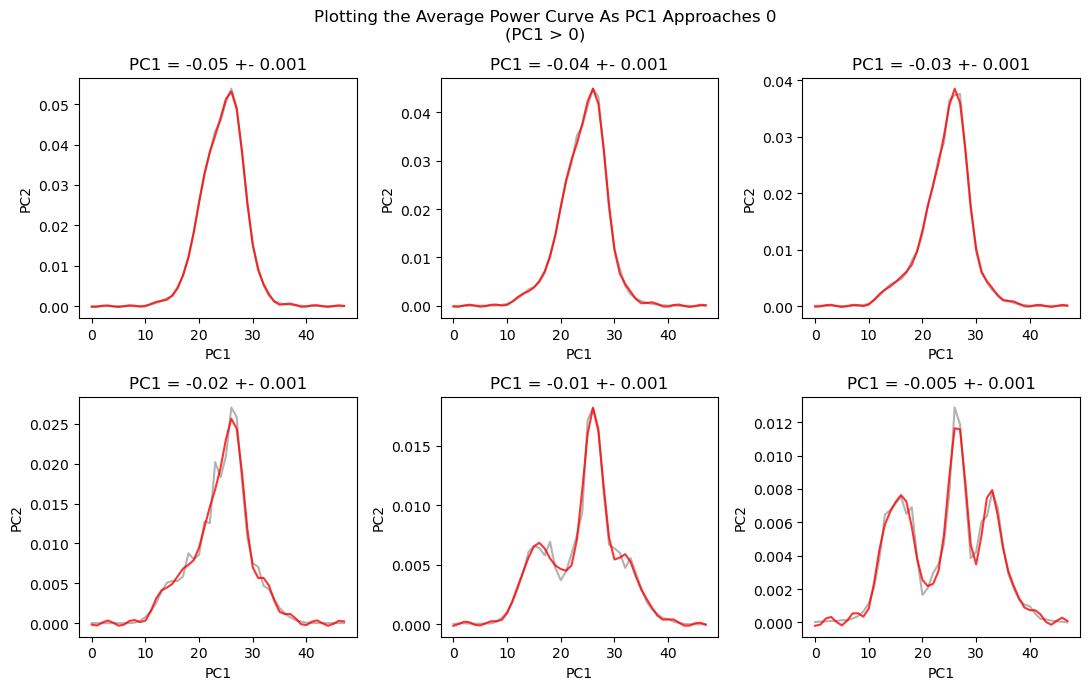

In [155]:
### Filter the data to find the high PC1 cutoff

fig,axes = plt.subplots(2,3, figsize=(11,7))
values = np.array([0.05, 0.04, 0.03, 0.02, 0.01, 0.005]) * -1
offset = 0.001
col = "recon_PC1"

for i,(value,ax) in enumerate(zip(values, axes.flatten())):
    df_zeros = df2.where((F.col(col) < (value + offset)) & (F.col(col) > (value - offset)))
    
    #######################################################
    # Print extra stats for the first offset
    if i==0:
        print("Viewing a subset of the data")
        df_zeros.show(5)
        
    print(f"Range = {value} +- {offset}\nNumber of rows = {df_zeros.count()}\n\n")
    
    ### Vectorize the lists and extract the mean powers/reconstructions
    df_zeros2 = vectorize_lists(df_zeros)

    try:
        zeros_mean_powers = list(df_zeros2.agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
        zeros_mean_recons = list(df_zeros2.agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])
        
        ### Set up x axis for plotting
        x = [i for i in np.arange(0,48)]
        
        ### Plot the mean values
        ax.plot(x, zeros_mean_powers, "k", alpha=0.3)
        ax.plot(x, zeros_mean_recons, "r", alpha=0.8)
        ax.set(xlabel="PC1", ylabel="PC2", title=f"PC1 = {value} +- {offset}")
    except:
        ax.axis("off")

plt.suptitle("Plotting the Average Power Curve As PC1 Approaches 0\n(PC1 > 0)")
plt.tight_layout()
plt.show()


## PC 1 high cutoff --> PC1 > -0.02

Viewing a subset of the data
+------------+-----+----------+--------------------+--------------------+--------------------+-------------------+
|          id|ss_id|stamp_date|     power_kW_values|     reconstructions|           recon_PC1|          recon_PC2|
+------------+-----+----------+--------------------+--------------------+--------------------+-------------------+
|      251157|24103|2020-06-06|[0.0, 0.0, 0.0, 0...|[-0.0034768193828...| -1.3085808943812454|0.20310123449815756|
| 25770106456|26267|2020-06-22|[0.0, 0.0, 0.0, 0...|[-0.0174892409681...| -1.1341190387161988|0.19829164000130506|
|180388978964|24278|2021-06-23|[0.0, 0.0, 0.0, 0...|[0.00958867718546...|-0.48211587515338306|0.20263037951720747|
|188978793757|12299|2020-06-06|[0.0, 0.0, 0.0, 0...|[0.02688962459321...| -1.0897192450616076|0.20073692928313847|
|249108198634|25880|2019-06-17|[0.0, 0.0, 0.0, 0...|[0.01516195714628...| -1.3148772913209832| 0.1967238482880052|
+------------+-----+----------+--------------------

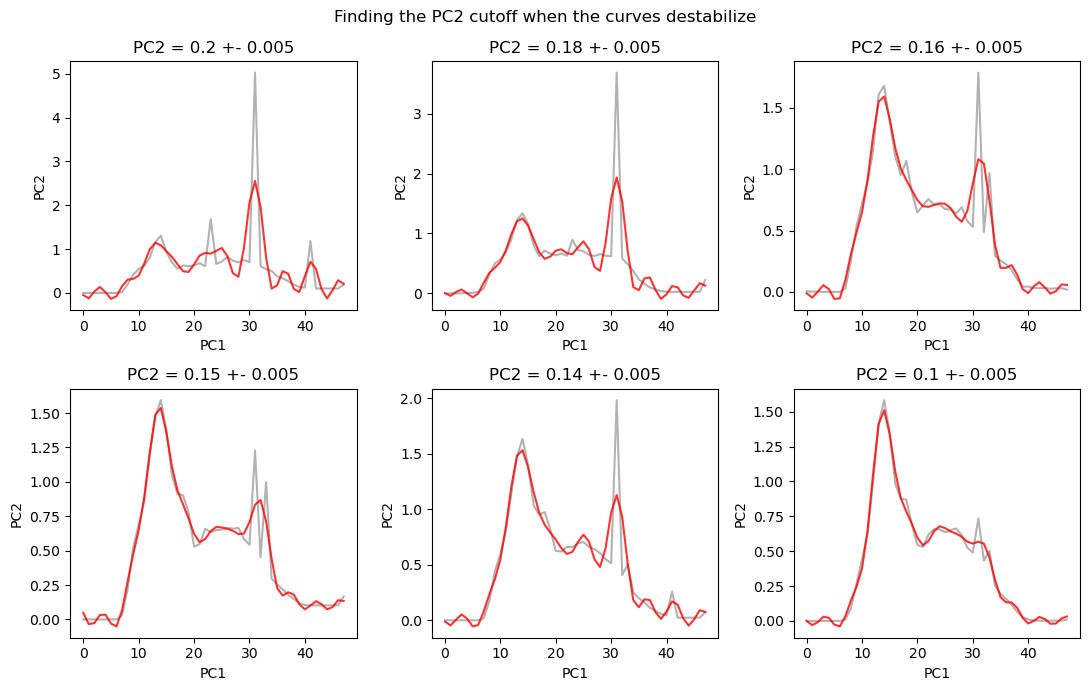

In [174]:
### Filter the data to find the high PC2 cutoff

fig,axes = plt.subplots(2,3, figsize=(11,7))
values = np.array([0.2, 0.18, 0.16, 0.15, 0.14, 0.1])
offset = 0.005
col = "recon_PC2"

for i,(value,ax) in enumerate(zip(values, axes.flatten())):
    df_zeros = df2.where((F.col(col) < (value + offset)) & (F.col(col) > (value - offset)))
    
    #######################################################
    # Print extra stats for the first offset
    if i==0:
        print("Viewing a subset of the data")
        df_zeros.show(5)
        
    print(f"Range = {value} +- {offset}\nNumber of rows = {df_zeros.count()}\n\n")
    
    ### Vectorize the lists and extract the mean powers/reconstructions
    df_zeros2 = vectorize_lists(df_zeros)
        
    zeros_mean_powers = list(df_zeros2.agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
    zeros_mean_recons = list(df_zeros2.agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])
    
    ### Set up x axis for plotting
    x = [i for i in np.arange(0,48)]
    
    ### Plot the mean values
    ax.plot(x, zeros_mean_powers, "k", alpha=0.3)
    ax.plot(x, zeros_mean_recons, "r", alpha=0.8)
    ax.set(xlabel="PC1", ylabel="PC2", title=f"PC2 = {value} +- {offset}")

plt.suptitle("Finding the PC2 cutoff when the curves destabilize")
plt.tight_layout()
plt.show()


## PC2 high cutoff --> PC2 > 0.16

Viewing a subset of the data
+------------+-----+----------+--------------------+--------------------+------------------+-------------------+
|          id|ss_id|stamp_date|     power_kW_values|     reconstructions|         recon_PC1|          recon_PC2|
+------------+-----+----------+--------------------+--------------------+------------------+-------------------+
|472446690234|16580|2016-08-15|[0.0, 0.0, 0.0, 0...|[-0.0183389357103...|-7.031215404680069|-0.5602233903191016|
+------------+-----+----------+--------------------+--------------------+------------------+-------------------+

Range = -7.0 +- 0.1
Number of rows = 1


Range = -6.5 +- 0.1
Number of rows = 1


Range = -6.0 +- 0.1
Number of rows = 13


Range = -5.75 +- 0.1
Number of rows = 16


Range = -5.5 +- 0.1
Number of rows = 29


Range = -5.25 +- 0.1
Number of rows = 39




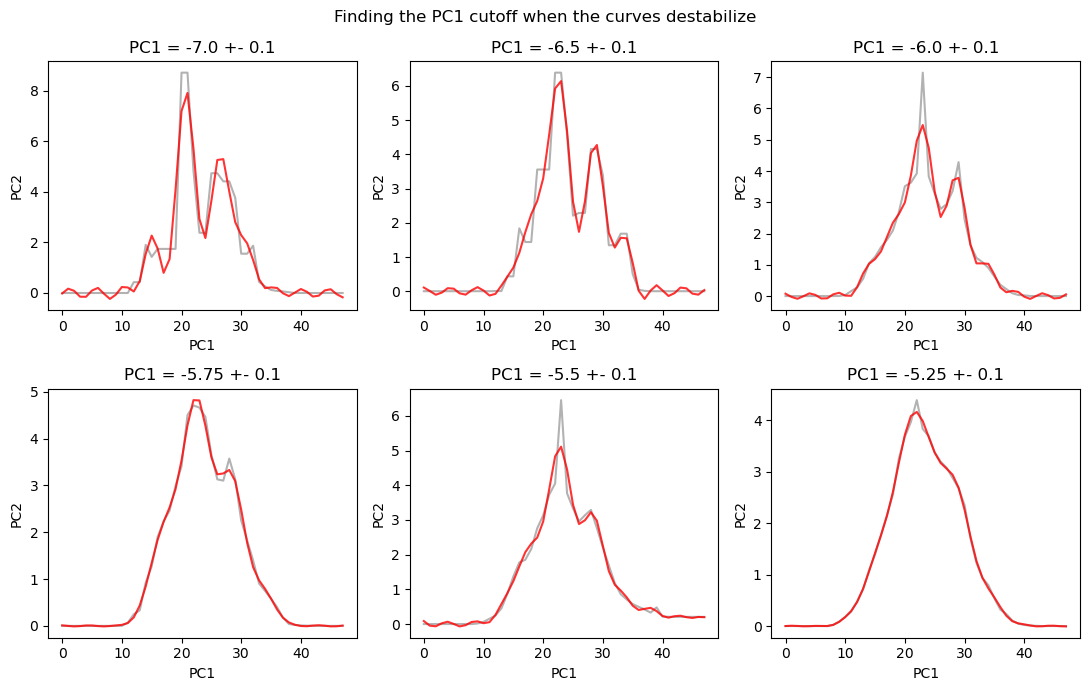

In [180]:
### Filter the data to find the low PC1 cutoff

fig,axes = plt.subplots(2,3, figsize=(11,7))
values = np.array([7, 6.5, 6, 5.75, 5.5, 5.25]) * -1
offset = 0.1
col = "recon_PC1"

for i,(value,ax) in enumerate(zip(values, axes.flatten())):
    df_zeros = df2.where((F.col(col) < (value + offset)) & (F.col(col) > (value - offset)))
    
    #######################################################
    # Print extra stats for the first offset
    if i==0:
        print("Viewing a subset of the data")
        df_zeros.show(5)
        
    print(f"Range = {value} +- {offset}\nNumber of rows = {df_zeros.count()}\n\n")
    
    ### Vectorize the lists and extract the mean powers/reconstructions
    df_zeros2 = vectorize_lists(df_zeros)
        
    zeros_mean_powers = list(df_zeros2.agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
    zeros_mean_recons = list(df_zeros2.agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])
    
    ### Set up x axis for plotting
    x = [i for i in np.arange(0,48)]
    
    ### Plot the mean values
    ax.plot(x, zeros_mean_powers, "k", alpha=0.3)
    ax.plot(x, zeros_mean_recons, "r", alpha=0.8)
    ax.set(xlabel="PC1", ylabel="PC2", title=f"PC1 = {value} +- {offset}")

plt.suptitle("Finding the PC1 cutoff when the curves destabilize")
plt.tight_layout()
plt.show()


## PC1 Low cutoff --> Possibly PC1 < -6

Viewing a subset of the data
+------------+-----+----------+--------------------+--------------------+--------------------+-------------------+
|          id|ss_id|stamp_date|     power_kW_values|     reconstructions|           recon_PC1|          recon_PC2|
+------------+-----+----------+--------------------+--------------------+--------------------+-------------------+
|429497119079| 3129|2013-07-07|[2.4003, 2.3614, ...|[1.71562778370767...|-0.09700775157087776|-0.5973546018556297|
|841813832913|12915|2015-02-17|[0.0, 0.0, 0.0, 0...|[-1.3153056956382...| -1.0957122392925127|-0.5902906261691614|
+------------+-----+----------+--------------------+--------------------+--------------------+-------------------+

Range = -0.6 +- 0.025
Number of rows = 2


Range = -0.525 +- 0.025
Number of rows = 2


Range = -0.5 +- 0.025
Number of rows = 7


Range = -0.475 +- 0.025
Number of rows = 14


Range = -0.45 +- 0.025
Number of rows = 17


Range = -0.4 +- 0.025
Number of rows = 42




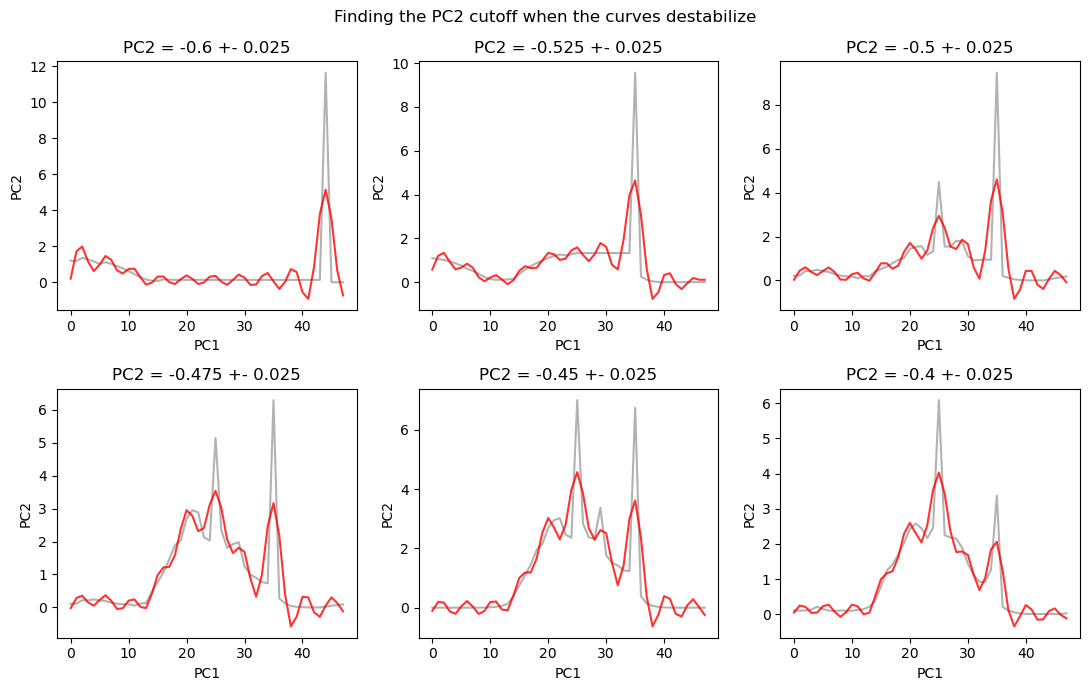

In [185]:
### Filter the data to find the high PC2 cutoff

fig,axes = plt.subplots(2,3, figsize=(11,7))
values = np.array([0.6, 0.525, 0.5, 0.475, 0.45, 0.4]) * -1
offset = 0.025
col = "recon_PC2"

for i,(value,ax) in enumerate(zip(values, axes.flatten())):
    df_zeros = df2.where((F.col(col) < (value + offset)) & (F.col(col) > (value - offset)))
    
    #######################################################
    # Print extra stats for the first offset
    if i==0:
        print("Viewing a subset of the data")
        df_zeros.show(5)
        
    print(f"Range = {value} +- {offset}\nNumber of rows = {df_zeros.count()}\n\n")
    
    ### Vectorize the lists and extract the mean powers/reconstructions
    df_zeros2 = vectorize_lists(df_zeros)
        
    zeros_mean_powers = list(df_zeros2.agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power")).collect()[0][0])
    zeros_mean_recons = list(df_zeros2.agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon")).collect()[0][0])
    
    ### Set up x axis for plotting
    x = [i for i in np.arange(0,48)]
    
    ### Plot the mean values
    ax.plot(x, zeros_mean_powers, "k", alpha=0.3)
    ax.plot(x, zeros_mean_recons, "r", alpha=0.8)
    ax.set(xlabel="PC1", ylabel="PC2", title=f"PC2 = {value} +- {offset}")

plt.suptitle("Finding the PC2 cutoff when the curves destabilize")
plt.tight_layout()
plt.show()


## PC2 low cutoff --> Possibly PC2 > -0.475

### Anomaly curve cutoffs

-6 < PC1 < -0.2

-0.475 < PC2 < 0.16

In [9]:
### Plot dataset with anomalies marked
# Boundary parameters
pc1_low, pc1_high, pc2_low, pc2_high = (-6, -0.2, -0.475, 0.16)
xborder = np.linspace(pc1_low, pc1_high, 10)
yborder = np.linspace(pc2_low, pc2_high, 10)
# Non-anomalous points
df_normal = df2.where((F.col("recon_PC1")>pc1_low) & (F.col("recon_PC1")<pc1_high) & (F.col("recon_PC2")>pc2_low) & (F.col("recon_PC2")<pc2_high)) \
               .select("recon_PC1", "recon_PC2").toPandas()
df_anomaly = df2.where((F.col("recon_PC1")<pc1_low) | (F.col("recon_PC1")>pc1_high) | (F.col("recon_PC2")<pc2_low) | (F.col("recon_PC2")>pc2_high)) \
               .select("recon_PC1", "recon_PC2").toPandas()
print("Total anomaly count:", len(df_anomaly))

Total anomaly count: 3111382


Text(0.5, 1.0, 'PCA Anomalies Identified')

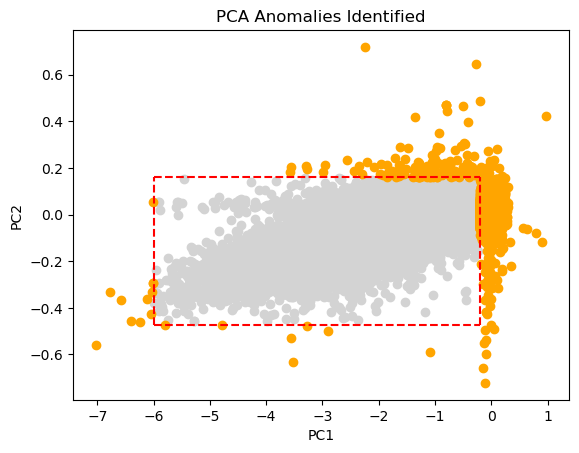

In [11]:
plt.plot(df_normal["recon_PC1"], df_normal["recon_PC2"], "o", color="lightgrey")
plt.plot(df_anomaly["recon_PC1"], df_anomaly["recon_PC2"], "o", color="orange")

plt.plot(xborder, np.repeat(pc2_low,10), "r--")
plt.plot(xborder, np.repeat(pc2_high,10), "r--")
plt.plot(np.repeat(pc1_low,10), yborder, "r--")
plt.plot(np.repeat(pc1_high,10), yborder,  "r--")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Anomalies Identified")

In [14]:
print("Number of rows with PC1 > -0.2:", len(df_anomaly[df_anomaly["recon_PC1"] > -0.2]))
print("Number of rows with PC1 < -6:", len(df_anomaly[df_anomaly["recon_PC1"] < -6]))
print("Number of rows with PC2 > 0.16:", len(df_anomaly[df_anomaly["recon_PC2"] > 0.16]))
print("Number of rows with PC2 < -0.475:", len(df_anomaly[df_anomaly["recon_PC2"] < -0.475]))

Number of rows with PC1 > -0.2: 3111215
Number of rows with PC1 < -6: 11
Number of rows with PC2 > 0.16: 172
Number of rows with PC2 < -0.475: 16
